# Установка пакетов разработки

In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install networkx
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


# Функция вычисления графовых характеристик

In [2]:
import torch
import networkx as nx
from torch_geometric.datasets import Planetoid, OGB_MAG, PPI
from torch_geometric.utils import to_networkx
from networkx.algorithms.cluster import clustering
from networkx.algorithms.centrality import degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality
from networkx.algorithms.smallworld import sigma

def compute_metrics(G, to_undirected=True):
    """ Функция для вычисления характеристик графа"""
    metrics = {}

    try:
        metrics['degree'] = dict(G.degree())
        metrics['diameter'] = nx.diameter(G) if nx.is_connected(G) else None
        metrics['clustering_coeff'] = nx.clustering(G)
        metrics['degree_cent'] = nx.degree_centrality(G)
        metrics['closeness_cent'] = nx.closeness_centrality(G)
        metrics['betweenness_cent'] = nx.betweenness_centrality(G)
        metrics['eigenvector_cent'] = nx.eigenvector_centrality(G, max_iter=1000)
        metrics['eccentricity'] = nx.eccentricity(G) if nx.is_connected(G) else None
        metrics['triangles'] = nx.triangles(G)
    except Exception as err:
        print(f"Error computing metrics: {err}")

    return metrics

# Загрузка датасетов

In [3]:
def load_cora():
    """Загрузка датасета Cora и конвертация в NetworkX-граф"""
    data = Planetoid(root='./data/Cora', name='Cora')[0]

    # Ручное преобразование в NetworkX-граф
    edge_index = data.edge_index.numpy()
    G = nx.Graph()

    # Добавляем рёбра
    for src, dst in zip(edge_index[0], edge_index[1]):
        G.add_edge(src, dst)

    # Добавляем узлы и их признаки
    for i in range(data.x.shape[0]):
        G.add_node(i, features=data.x[i].numpy())

    return G

cora_graph = load_cora()

Processing...
Done!


# Метод визуализации распределений графовых характеристик

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_distribution(metric_data, metric_name, dataset_name):
    """Функция для визуализации распределений"""
    plt.figure(figsize=(8, 6))
    sns.histplot(list(metric_data.values()), kde=True, bins=30)
    plt.title(f'Распределение характеристики {metric_name} in {dataset_name}')
    plt.xlabel(f'Значение для {metric_name}')
    plt.ylabel('Частота значения')
    plt.show()

def visualize_metrics(dataset_name, metrics):
    for metric_name, metric_data in metrics.items():
        if isinstance(metric_data, dict):
            plot_metric_distribution(metric_data, metric_name, dataset_name)
        else:
            print(f"{metric_name}: {metric_data}")

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_distribution_many(metric_data_list, metric_name, dataset_names, title=None):
    """
    Функция для визуализации распределений нескольких наборов данных.
    metric_data_list: список словарей метрик (list of dicts)
    metric_name: название графовой характеристики
    dataset_names: список названий датасетов для каждой группы данных
    title: заголовок графика
    """
    plt.figure(figsize=(10, 8))

    # Для каждого набора данных добавляем гистограмму
    for metric_data, dataset_name in zip(metric_data_list, dataset_names):
        sns.histplot(
            list(metric_data.values()),
            # kde=True,
            bins=30,
            label=dataset_name,
            alpha=0.5
        )

    plt.title(title or f'Распределение характеристики {metric_name}')
    plt.xlabel(f'Значение для {metric_name}')
    plt.ylabel('Частота значения')
    plt.legend()
    plt.show()

def visualize_metrics_many(dataset_names, metrics_list):
    """
    Функция для визуализации распределений метрик для нескольких наборов данных.
    dataset_names: список названий графов (исходный граф + подграфы)
    metrics_list: список словарей метрик для каждого набора данных
    """
    # Собираем все названия характеристик из первого набора данных
    metric_names = metrics_list[0].keys()

    # Для каждой характеристики визуализируем распределения
    for metric_name in metric_names:
        metric_data_list = []
        for metrics in metrics_list:
          if isinstance(metrics[metric_name], dict):
            metric_data_list.append(metrics[metric_name])
          elif isinstance(metrics[metric_name], list) and metrics[metric_name]:
            metric_data_list.append(metrics[metric_name][0])

        plot_metric_distribution_many(
            metric_data_list,
            metric_name,
            dataset_names,
            title=f'Распределение {metric_name} для разных графов'
        )


# Сэмплирование CoraML

In [6]:
import random

def sample_subgraph(G, sample_ratio):
    """Функция для сэмплирования подграфа"""
    num_nodes = len(G.nodes)
    sampled_nodes = random.sample(list(G.nodes), int(num_nodes * sample_ratio))
    subgraph = G.subgraph(sampled_nodes)

    # Проверяем связность и берем крупнейшую компоненту
    if not nx.is_connected(subgraph):
        largest_cc = max(nx.connected_components(subgraph), key=len)
        subgraph = subgraph.subgraph(largest_cc).copy()

    return nx.Graph(subgraph)

def analyze_subgraphs(G, sample_ratios, num_samples=5):
    """Анализ распределений характеристик подграфов"""
    results = {}
    for ratio in sample_ratios:
        print(f"\nАнализ подграфа с {int(ratio * 100)}% исходных вершин...")
        metrics_list = []
        for _ in range(num_samples):
            subgraph = sample_subgraph(G, ratio)
            metrics = compute_metrics(subgraph)
            metrics_list.append(metrics)

        # Агрегируем результаты по метрикам
        aggregated_metrics = {}
        for key in metrics_list[0].keys():
            aggregated_metrics[key] = [m[key] for m in metrics_list if isinstance(m[key], dict)]
        results[ratio] = aggregated_metrics

    return results

Анализ исходного графа (Cora)...


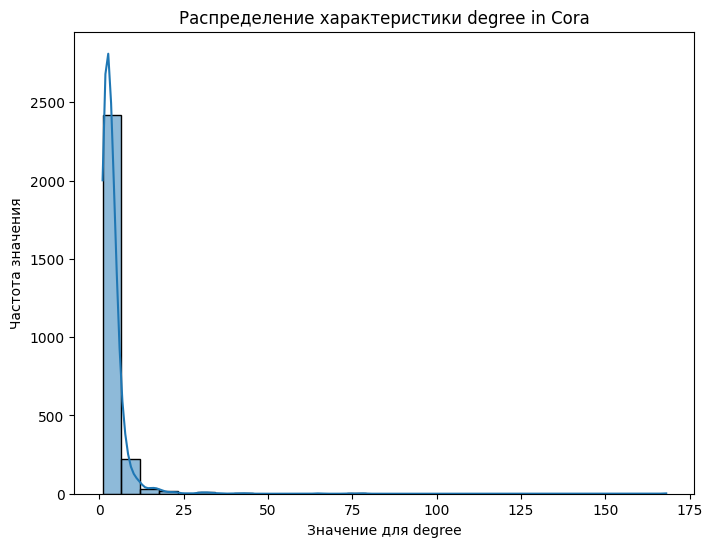

diameter: None


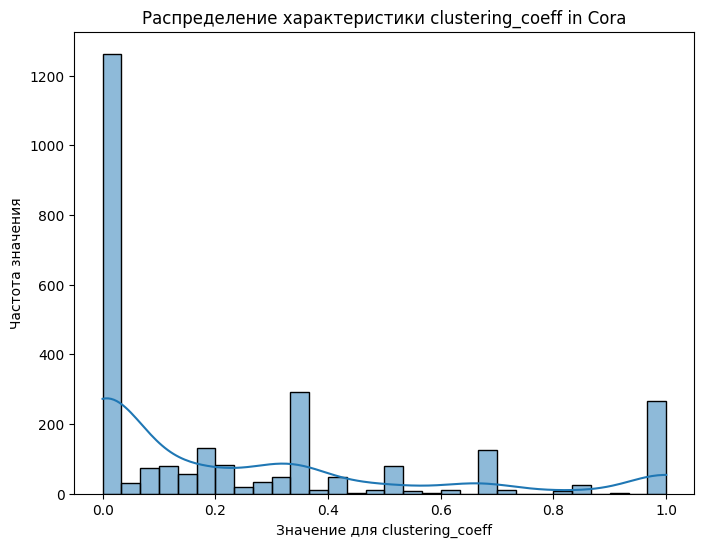

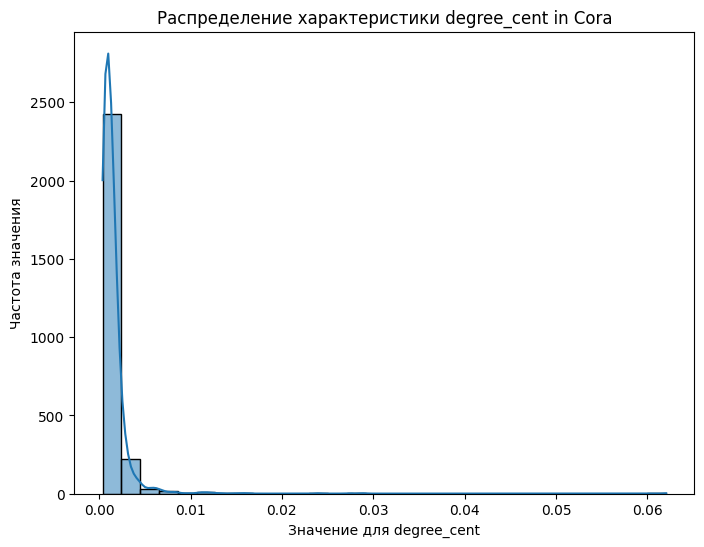

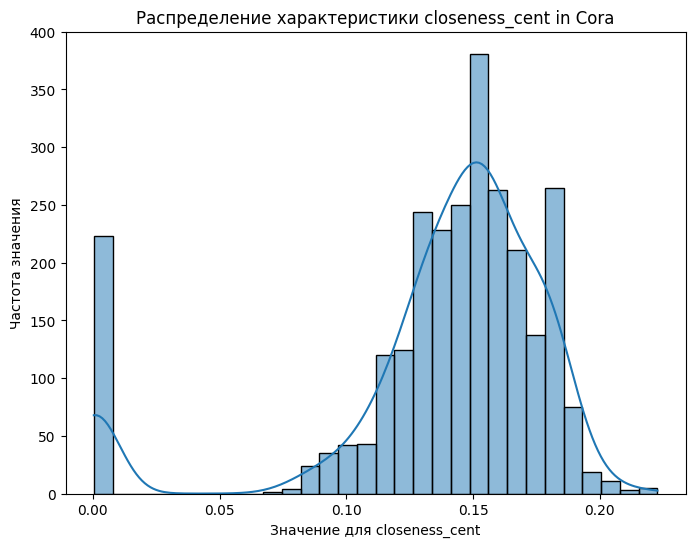

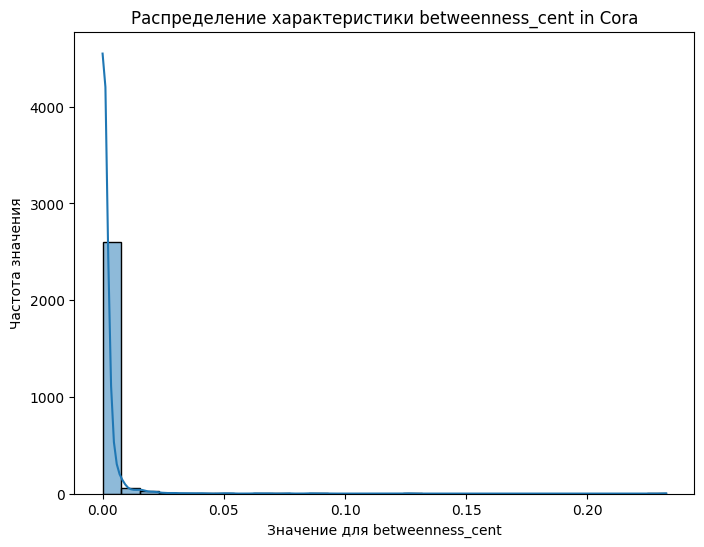

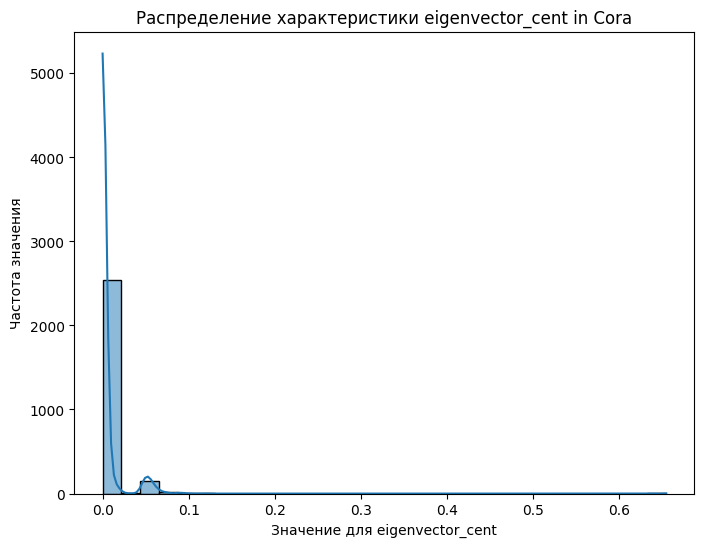

eccentricity: None


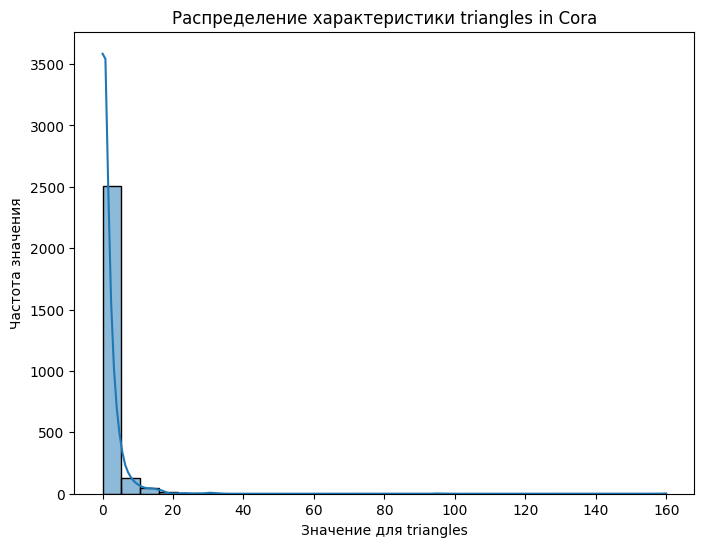

In [7]:
# Анализ исходного графа
print("Анализ исходного графа (Cora)...")
cora_metrics = compute_metrics(cora_graph)
visualize_metrics("Cora", cora_metrics)

In [8]:
cora_metrics.keys()

dict_keys(['degree', 'diameter', 'clustering_coeff', 'degree_cent', 'closeness_cent', 'betweenness_cent', 'eigenvector_cent', 'eccentricity', 'triangles'])

In [9]:
type(cora_metrics['degree'])

dict

In [10]:
# Анализ подграфов
sample_ratios = [0.5, 0.6, 0.7, 0.8, 0.85]
subgraph_results = analyze_subgraphs(cora_graph, sample_ratios)


Анализ подграфа с 50% исходных вершин...

Анализ подграфа с 60% исходных вершин...

Анализ подграфа с 70% исходных вершин...

Анализ подграфа с 80% исходных вершин...

Анализ подграфа с 85% исходных вершин...


In [11]:
subgraph_results[0.5].keys()

dict_keys(['degree', 'diameter', 'clustering_coeff', 'degree_cent', 'closeness_cent', 'betweenness_cent', 'eigenvector_cent', 'eccentricity', 'triangles'])

In [12]:
dataset_names = ["Исходный граф", "Подграф 50%", "Подграф 60%", "Подграф 70%", "Подграф 80%", "Подграф 85%"]
metrics_list = [cora_metrics, subgraph_results[0.5], subgraph_results[0.6], subgraph_results[0.7], subgraph_results[0.8], subgraph_results[0.85]]

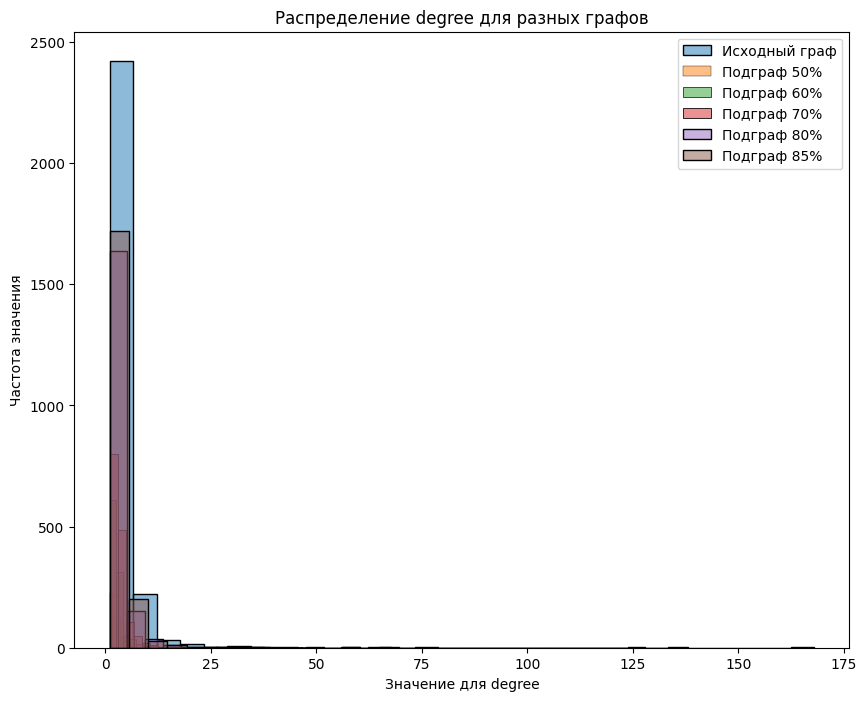

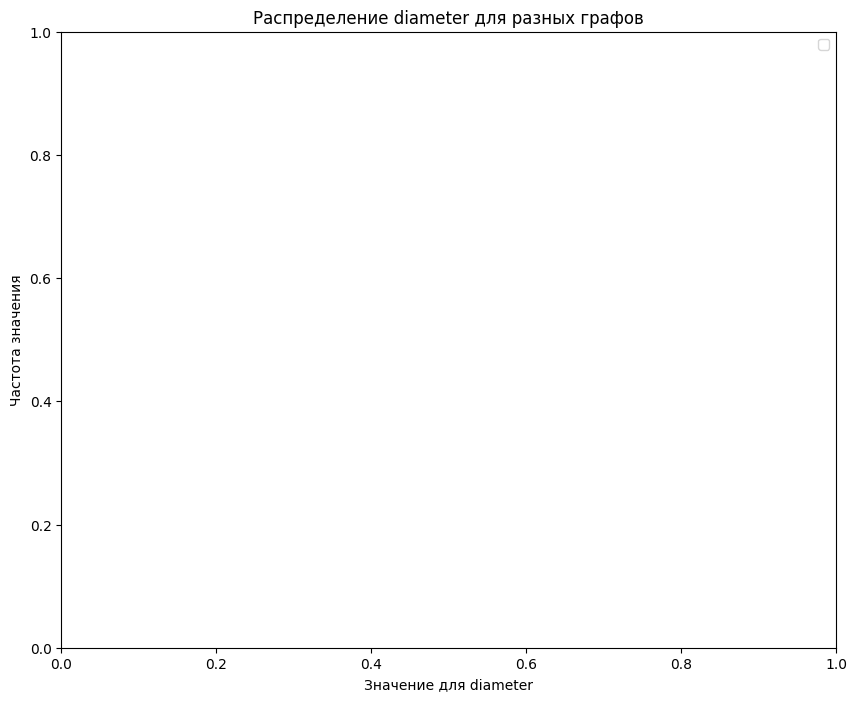

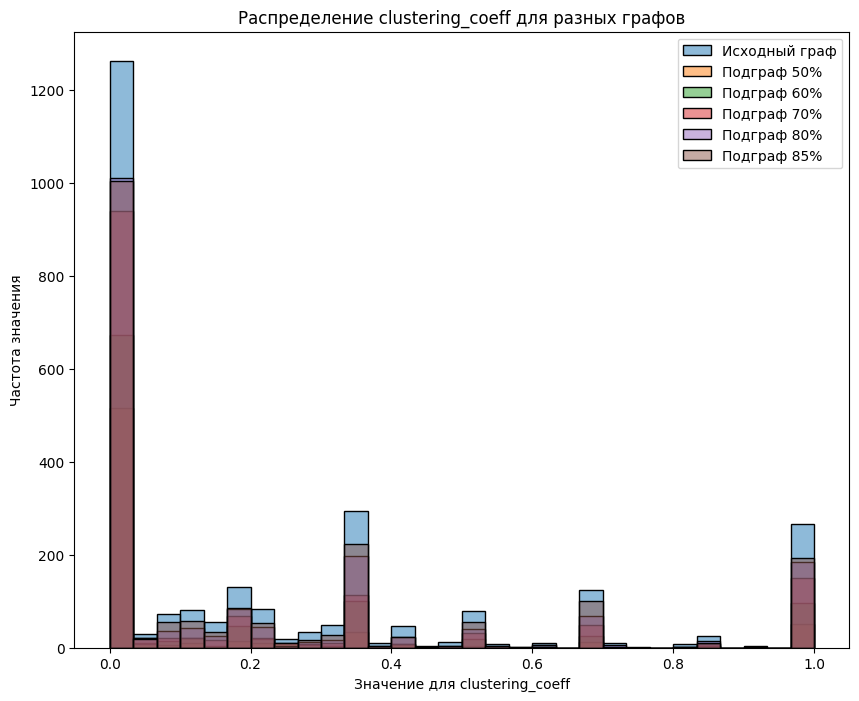

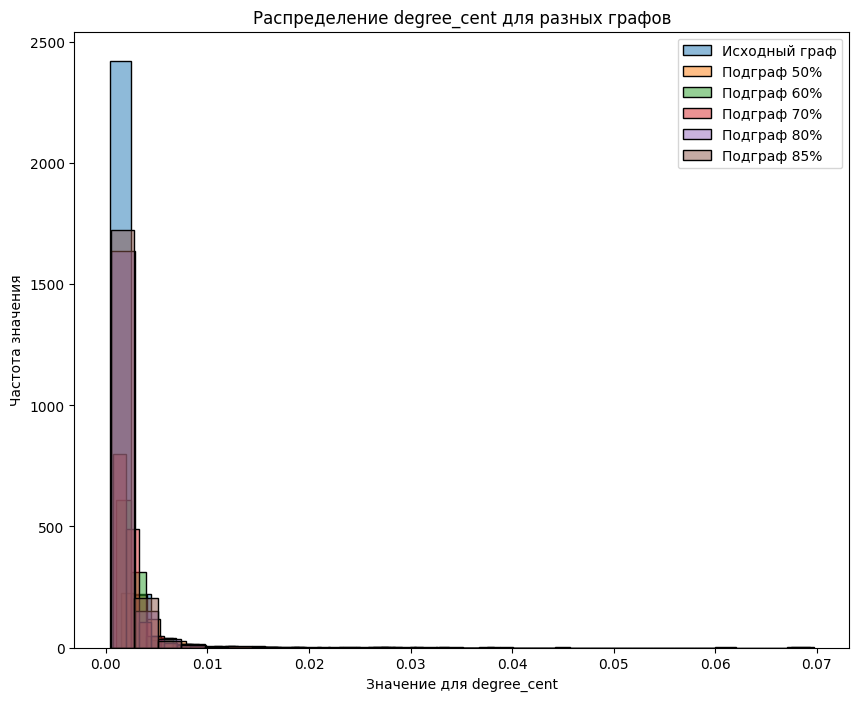

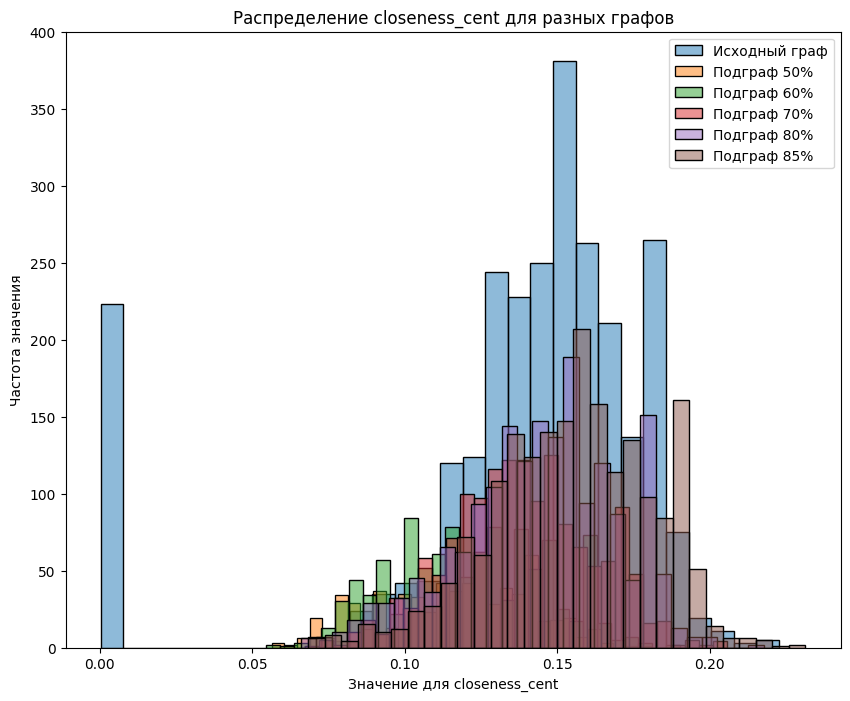

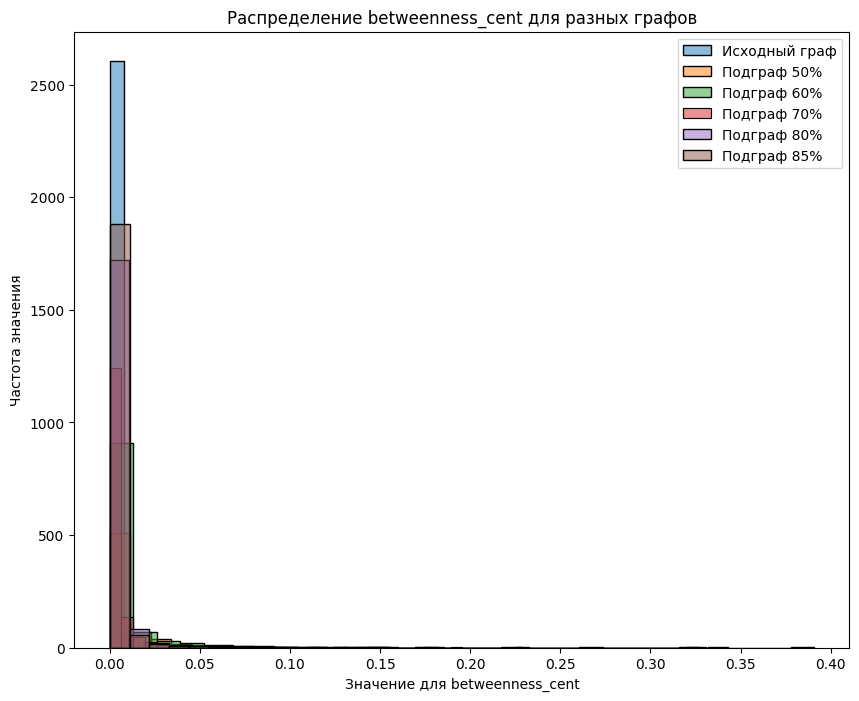

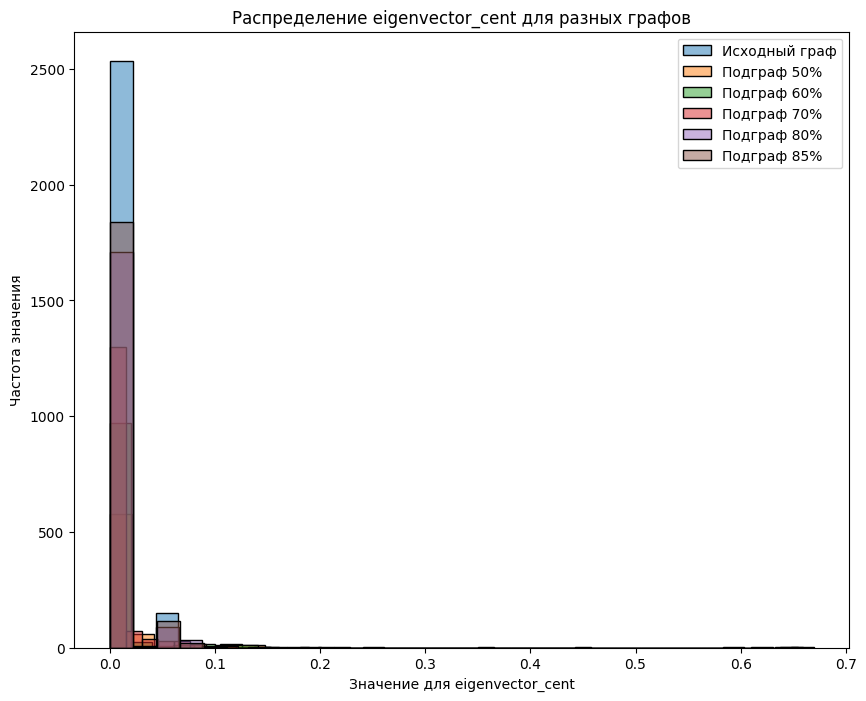

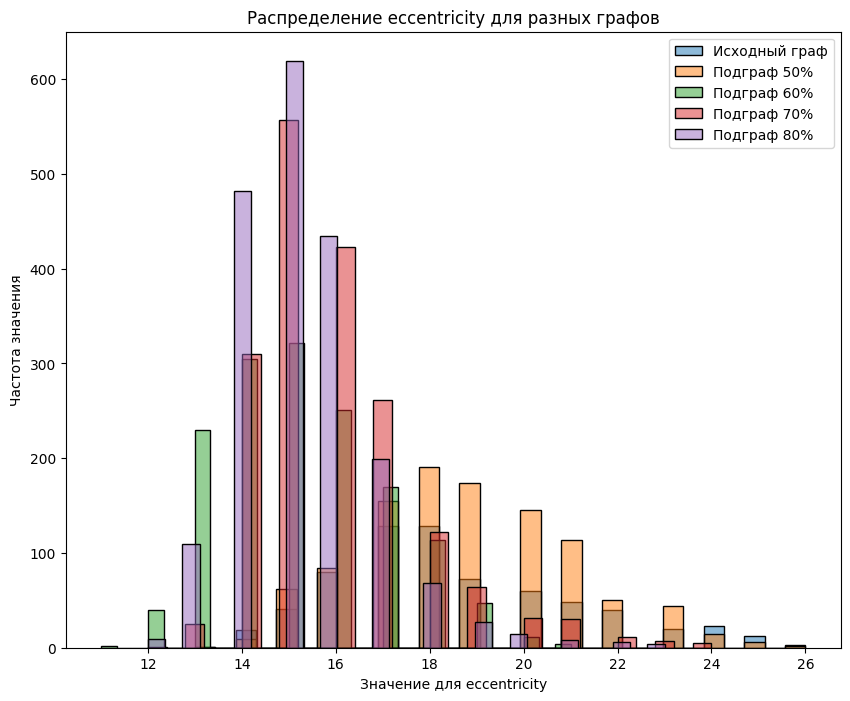

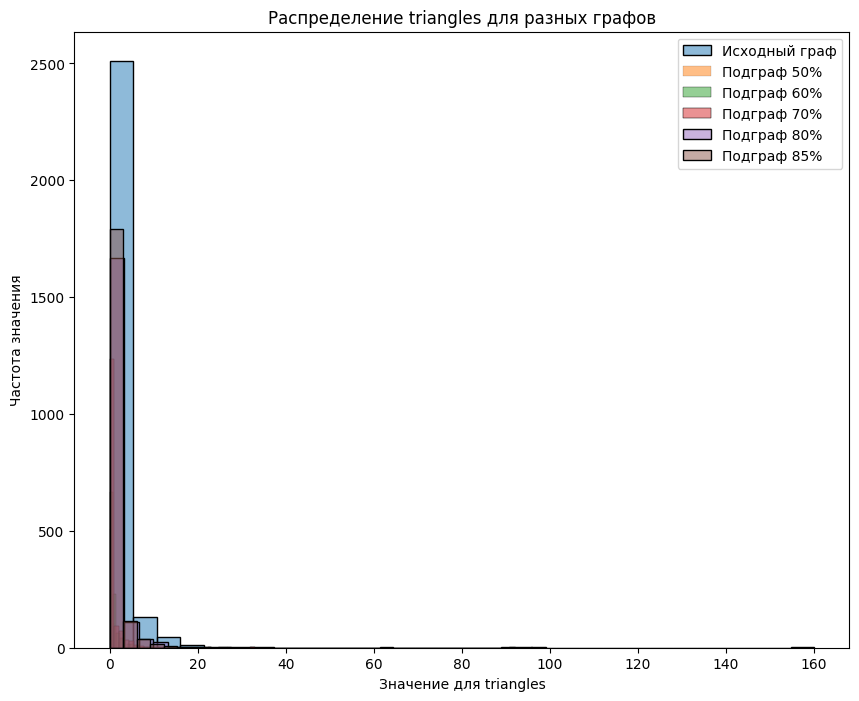

In [22]:
visualize_metrics_many(dataset_names, metrics_list)